In [1]:
import numpy as np
import mne
import re
import matplotlib.pyplot as plt
from collections import OrderedDict

import tracemalloc


In [2]:
%load_ext IPython.extensions.autoreload
%autoreload 2

import hypyp
import hypyp.fnirs as fnirs
from hypyp.wavelet.pywavelets_wavelet import PywaveletsWavelet
from hypyp.profiling import MemoryMonitor


## Download and load raw data from disk

In [3]:
# Download data

browser = fnirs.DataBrowser()
previous_count = len(browser.paths)
browser.download_demo_dataset()
#print(loader.list_all_files())


'/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers'

In [4]:
# Get the paths for dyads

paths = [path for path in browser.list_all_files() if 'fathers' in path]

dyad_paths = dict()

pattern = re.compile(r'.*/(FCS\d\d)/.*')
pattern_parent = re.compile(r'.*/parent/.*')
pattern_child = re.compile(r'.*/child/.*')

for path in paths:
    matches = pattern.match(path)
    key = matches[1]
    if not key in dyad_paths.keys():
        dyad_paths[key] = ['', '']
    
    if pattern_parent.match(path) is not None:
        dyad_paths[key][0] = path

    if pattern_child.match(path) is not None:
        dyad_paths[key][1] = path


print(dyad_paths)
    

{'FCS01': ['/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS01/parent/NIRS-2019-09-28_002.hdr', '/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS01/child/NIRS-2019-09-28_002.hdr'], 'FCS02': ['/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS02/parent/NIRS-2019-10-06_004.hdr', '/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS02/child/NIRS-2019-10-06_004.hdr'], 'FCS03': ['/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS03/parent/NIRS-2019-10-12_003.hdr', '/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS03/child/NIRS-2019-10-12_003.hdr'], 'FCS04': ['/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS04/parent/NIRS-2019-10-12_001.hdr', '/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS04/child/NIRS-2019-10-12_001.hdr'], 'FCS05': ['/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS05/parent/NIRS-2019-10

In [5]:
channel_roi = fnirs.ChannelROI(OrderedDict({
    'Source1': [ 'S1_D1 hbo', 'S1_D1 hbr', 'S1_D2 hbo', 'S1_D2 hbr', ],
    'Source2': [ 'S2_D1 hbo', 'S2_D1 hbr', 'S2_D3 hbo', 'S2_D3 hbr', ],
    'Source3': [ 'S3_D2 hbo', 'S3_D2 hbr', 'S3_D3 hbo', 'S3_D3 hbr', 'S3_D4 hbo', 'S3_D4 hbr', ],
    'Source4': [ 'S4_D2 hbo', 'S4_D2 hbr', 'S4_D4 hbo', 'S4_D4 hbr', 'S4_D5 hbo', 'S4_D5 hbr', ],
    'Source5': [ 'S5_D3 hbo', 'S5_D3 hbr', 'S5_D4 hbo', 'S5_D4 hbr', 'S5_D6 hbo', 'S5_D6 hbr', ],
    'Source6': [ 'S6_D4 hbo', 'S6_D4 hbr', 'S6_D5 hbo', 'S6_D5 hbr', 'S6_D6 hbo', 'S6_D6 hbr', ],
    'Source7': [ 'S7_D5 hbo', 'S7_D5 hbr', 'S7_D7 hbo', 'S7_D7 hbr', ],
    'Source8': [ 'S8_D6 hbo', 'S8_D6 hbr', 'S8_D7 hbo', 'S8_D7 hbr', ],
}))


## Intra subject validation

In [6]:
# Get connectivity matrix intra-subject for validation

dyad_key = list(dyad_paths.keys())[0]
dyad_path = list(dyad_paths.values())[0][0]
#tasks = [('first_10_seconds', 0, 10), ('second_10_seconds', 10, 20)]
#tasks = [('foo', 0, 120)]
tasks = [('first_minute', 0, 60)]
#tasks = []

subject = fnirs.Subject(label='Subject 0', tasks_time_range=tasks, channel_roi=channel_roi).load_file(dyad_path, fnirs.MnePreprocessor(), preprocess=True)
# full recording
#subject = fnirs.Subject(label='Subject 0').load_file(dyad_path, fnirs.MnePreprocessor(), preprocess=True)

wavelet = PywaveletsWavelet()
with MemoryMonitor():
    for i in range(10):
        dyad_intra_subject = fnirs.Dyad(subject, subject, label=f'intra-subject ({dyad_key})').compute_wtcs(ch_match='hbo', downsample=100, wavelet=wavelet)



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


[MemoryMonitor] allocated: 23.54 M, peak: 40.23 M


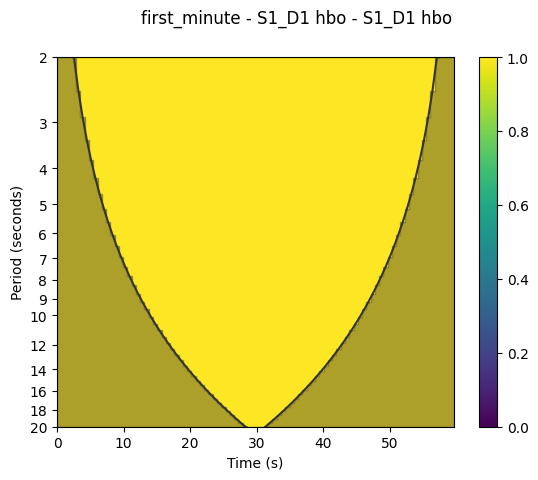

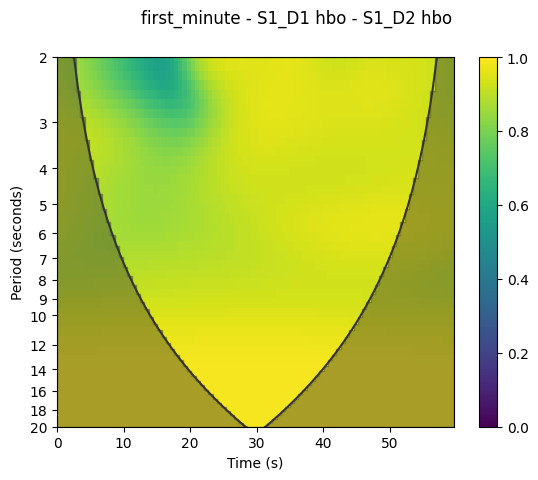

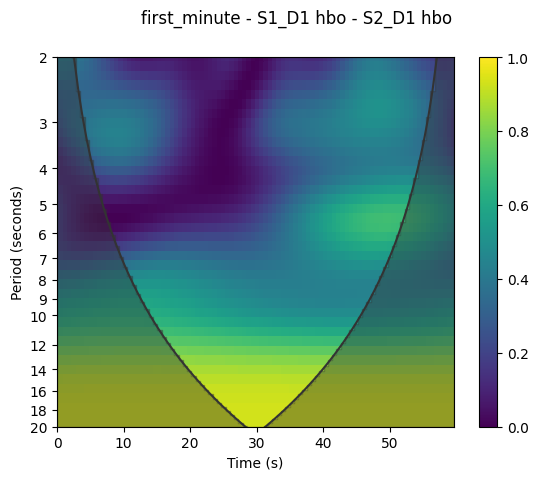

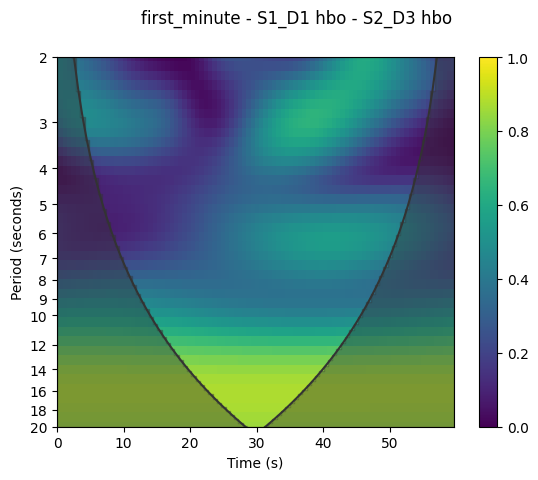

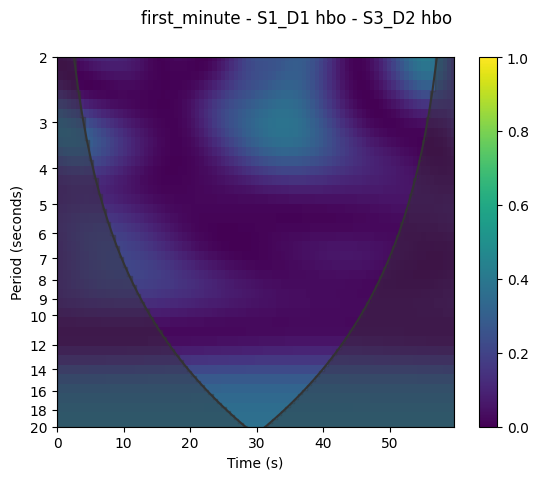

In [7]:
for i in range(5):
    dyad_intra_subject.plot_wtc(dyad_intra_subject.wtcs[i])
    plt.show()


## Cohort


/home/patrice/work/ppsp/HyPyP-synchro/hypyp/plots.py:208: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_s1 = df_s1.pivot_table(index=field1, columns=field2, values='coherence', aggfunc='mean')
/home/patrice/work/ppsp/HyPyP-synchro/hypyp/plots.py:209: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_s2 = df_s2.pivot_table(index=field2, columns=field1, values='coherence', aggfunc='mean')
/home/patrice/work/ppsp/HyPyP-synchro/hypyp/plots.py:210: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_

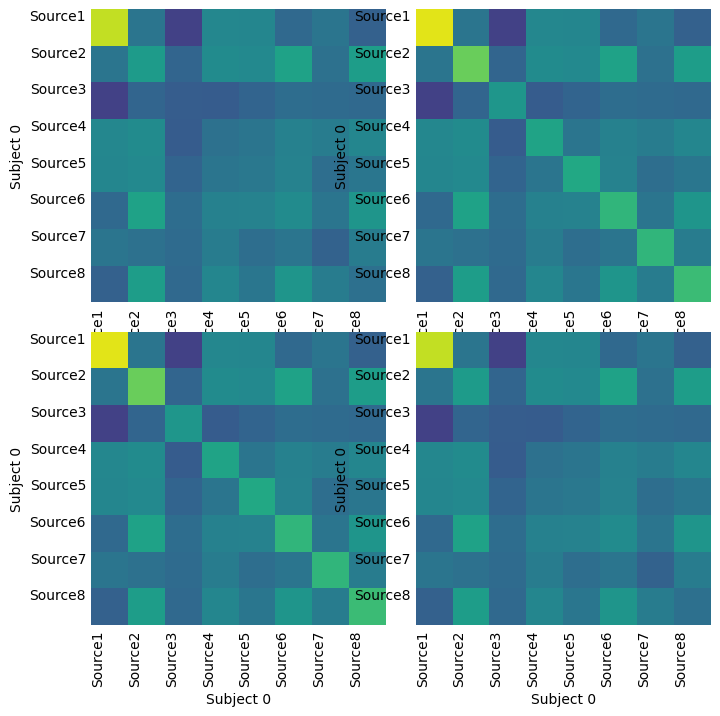

In [8]:
_ = dyad_intra_subject.plot_coherence_matrix_per_roi()


In [9]:
# Instanciate subjects and dyads objects

preprocessor = fnirs.MnePreprocessor()
#tasks = [
#    ('first_10_seconds', 0, 10),
#    ('20_to_40_seconds', 20, 40),
#]
tasks = [
    ('first_30_seconds', 0, 30),
    ('second_minute', 60, 120),
]

#[MemoryMonitor] allocated: 21.37 M, peak: 36.50 M
with MemoryMonitor():
    all_dyads = []

    # truncate for this example
    dyad_paths_keys = list(dyad_paths.keys())[:6]

    for dyad_key in dyad_paths_keys:
        path_parent, path_child = dyad_paths[dyad_key]

        parent = fnirs.Subject(label=f'Parent {dyad_key}', tasks_time_range=tasks, channel_roi=channel_roi).load_file(path_parent, preprocessor)
        child = fnirs.Subject(label=f'Child {dyad_key}', tasks_time_range=tasks, channel_roi=channel_roi).load_file(path_child, preprocessor)

        dyad = fnirs.Dyad(parent, child, label=dyad_key)

        all_dyads.append(dyad)

    cohort = fnirs.Cohort(all_dyads)


    


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [10]:
# Preprocess all dyads
with MemoryMonitor():
    old_level = mne.set_log_level(verbose='WARNING', return_old_level=True)
    cohort.preprocess(preprocessor)
    mne.set_log_level(verbose=old_level)

[MemoryMonitor] allocated: 0 B, peak: 424 B


In [11]:
# use caching to avoid recomputing continuous wavelet transforms all the time
# the cache dictionary is shared by all dyads
cache = dict()
wavelet = PywaveletsWavelet(cache=cache)


In [12]:


# Compute Wavelet Coherence for every dyad
with MemoryMonitor():
    #cohort.compute_wtcs(verbose=True, ch_match='hbo', wavelet=wavelet, with_intra=True, downsample=100)
    cohort.compute_wtcs(verbose=True, ch_match='hbo', wavelet=wavelet, with_intra=True, downsample=100, keep_wtcs=False)


Running Wavelet Coherence for dyad "FCS01" on pair "first_30_seconds - S1_D1 hbo - S1_D1 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "first_30_seconds - S1_D1 hbo - S1_D2 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "first_30_seconds - S1_D1 hbo - S2_D1 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "first_30_seconds - S1_D1 hbo - S2_D3 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "first_30_seconds - S1_D1 hbo - S3_D2 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "first_30_seconds - S1_D1 hbo - S3_D3 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "first_30_seconds - S1_D1 hbo - S3_D4 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "first_30_seconds - S1_D1 hbo - S4_D2 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "first_30_seconds - S1_D1 hbo - S4_D4 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "first_30_seconds - S1_D1 hbo - S4_D5 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "first_30

/home/patrice/work/ppsp/HyPyP-synchro/hypyp/plots.py:208: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_s1 = df_s1.pivot_table(index=field1, columns=field2, values='coherence', aggfunc='mean')
/home/patrice/work/ppsp/HyPyP-synchro/hypyp/plots.py:209: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_s2 = df_s2.pivot_table(index=field2, columns=field1, values='coherence', aggfunc='mean')
/home/patrice/work/ppsp/HyPyP-synchro/hypyp/plots.py:210: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_

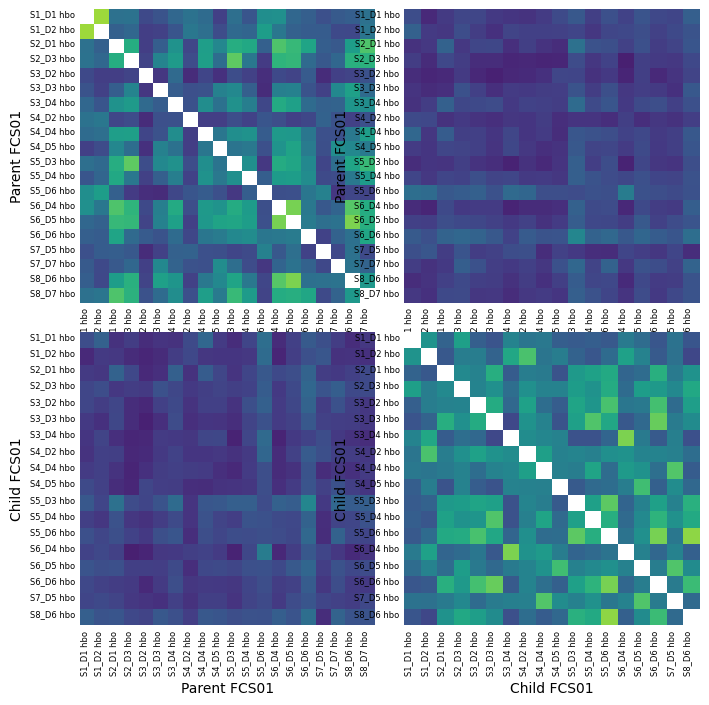

In [14]:

dyad = cohort.dyads[0]
_ = dyad.plot_coherence_matrix_per_channel()


In [15]:
# Save to disk

results_file_path = '../data/results/fnirs_cohort_example.pickle'
cohort.save_pickle(results_file_path)


In [17]:
feather_file_path = '../data/results/fnirs_cohort_example.feather'
cohort.save_feather(feather_file_path)


In [20]:
import sys
sys.getsizeof(cache)

26032